In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import utils.ssvep_analysis as sa

In [2]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    return eeg_data, severity

def preprocess_data(eeg_data):
    eeg_data = sa.remove_artefacts(eeg_data)
    eeg_data = sa.apply_ransac_detrending(eeg_data)
    eeg_data = sa.apply_highpass_filter(eeg_data)
    eeg_data = sa.apply_lowpass_filter(eeg_data)
    eeg_data = sa.apply_notch_filter(eeg_data)
    return eeg_data

def process_file(file_path):
    eeg_data, severity = read_data(file_path)
    eeg_data = preprocess_data(eeg_data)
    cca, _ = sa.compute_cca(eeg_data)
    coefs = cca.coef_
    coefs = np.sqrt(np.sum(coefs**2, axis=0))
    coefs = coefs / np.sqrt(np.sum(coefs**2))
    return [severity] + list(coefs)

def process_directory(directory_path):
    coefs_list = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        coefs = process_file(file_path)
        coefs_list.append(coefs)
    df = pd.DataFrame(coefs_list)
    return df

def process_directory_list(directory_list):
    df_list = []
    for directory in directory_list:
        df_list.append(process_directory('../data/' + directory))
    df = pd.concat(df_list)
    return df

directory_list = ['2024-01-12', '2024-01-19', '2024-01-22']
df = process_directory_list(directory_list)

In [3]:
df.columns = ['severity', 'PO7', 'O1', 'PO3', 'Oz', 'Pz', 'O2', 'PO4', 'PO8']
print(df.shape)
df.head()

(92, 9)


,severity,PO7,O1,PO3,Oz,Pz,O2,PO4,PO8
0,0.00,0.104440,0.140519,0.225510,0.541216,0.519895,0.524218,0.270926,0.084150
1,0.93,0.031849,0.383976,0.077766,0.360420,0.135406,0.443953,0.255332,0.659526
2,0.79,0.058931,0.233359,0.494062,0.683797,0.322311,0.141973,0.291924,0.145380
3,0.00,0.059786,0.414783,0.625246,0.576023,0.030110,0.041723,0.024868,0.313655
4,0.00,0.052571,0.418845,0.524989,0.082314,0.037224,0.666908,0.108076,0.285629


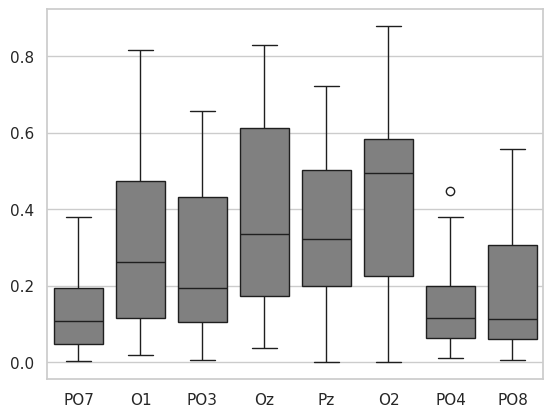

In [4]:
sns.boxplot(data=df[df['severity'] == 0][['PO7', 'O1', 'PO3', 'Oz', 'Pz', 'O2', 'PO4', 'PO8']], color='grey');

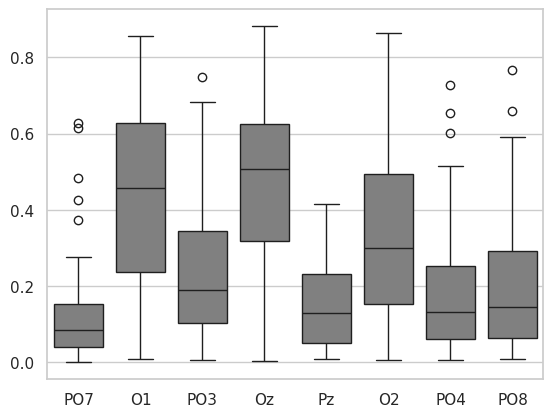

In [5]:
sns.boxplot(data=df[df['severity'] > 0.5][['PO7', 'O1', 'PO3', 'Oz', 'Pz', 'O2', 'PO4', 'PO8']], color='grey');